# Hough Transform
Ken Iiyoshi (ki573)\
22 Sept 2019\
Instructor: Tadesse Mulugeta

## Hough Transform Line Parametrization

### 1) Show that if you use the line equation ρ = xcosθ + ysinθ, each image point (x, y) results in a sinusoid in (ρ, θ) Hough space. Relate the amplitude and phase of the sinusoid to the point (x, y).


Any given point (x,y) maps to ρ = xcosθ + ysinθ with a uniquely constrained x and y. ρ is a sum of two sinusoids, so it will also have a sinusoid in Hough space. 

The output's amplitude corresponds to ρ_max, so it can be found by setting dρ/dθ =0: 

dρ/dθ = 0 = -x sin(θ) + y cos(θ)\
x sin(θ) = y cos(θ)\
y/x = tan(θ)\
θ =arctan(y/x)

Plugging this into the line equation gives:\
ρ_max = sqrt(x^2 + y^2)

This is simply vector magnitude of the point from the origin. In fact, the vector's phase relative to the x-axis in the image space maps to the phase(θ) of the sinusoid in the Hough space. Thus:

phase = θ = arctan(y/x).


### 2) Why do we parametrize the line in terms (ρ, θ) instead of the slope and intercept (m, c)? Express the slope and intercept in terms of (ρ, θ).

The (m,c) parameter space is unbounded, where as the (ρ,θ) parameter space is bounded from 0 to 2π and 0 to ρ_max respectively. Rearranging the line equation into slope-intercept form:

ρ = xcosθ + ysinθ\
ysinθ = ρ - xcosθ\
y = -cotθ x + ρ/sinθ

Hence, slope= -cotθ and intercept = ρ/sinθ.

### 3) Assuming that the image points (x, y) are in an image of width W and height H, that is, x ∈ [1,W], y ∈ [1,H], what is the maximum absolute value of ρ, and what is the range for θ?

ρ_max = sqrt(x^2 + y^2) = sqrt(W^2 + H^2)\
-π/2 <= θ < π/2, since this range worked for the code below. (other ranges like 0 to 2π would work but to a lesser extent.) It seems cruicial to have a specific range as that affect the trigonometric ratio of the answer for drawing lines based on hough peaks.

### 4) For point (10,10) and points (20,20) and (30,30) in the image, plot the corresponding sinusoid waves in Hough space, and visualize how their intersection point defines the line. What is (m, c) for this line? Please use Matlab to plot the curves and report the result in your write-up.

As seen in the figure, the intersection point ia at (3π/4, 0). This means that ρ = xcosθ + ysinθ becomes:

0 = xcos(3π/4) + ysin(3π/4)\
0.7071067812x = 0.7071067812y\
y=x

Which is an exact linear fit for the three points (slope = 1, x/y-intercepts:0)!


<img src="files/hough_manual.jpg">

MATLAB code:\
clear;\
theta = 0:0.01:2*pi;\
hold on;\
legend('(10,10)','(20,20)','(30,30)');\
title("Hough Transform of 3 points, (10,10), (20,20), and (30,30)")\
plot(theta,10*cos(theta) + 10*sin(theta))\
plot(theta,20*cos(theta) + 20*sin(theta))\
plot(theta,30*cos(theta) + 30*sin(theta))\
legend('(10,10)','(20,20)','(30,30)');\
grid on;\
saveas(gcf, 'hough_manual.jpg');\
hold off;


## Implementation

See the cell below for the code.\
\
Input image is located in the folder "test_images". Set the input address in the imread() functino to "test_images/test1.bmp" or "test_images/test2.bmp" to test each sample images respectively.\
\
Output image result for test1 and test2 is located in the folder "results/test1" and "results/test2" respectively. To ensure each results are saved in the correct folder, modify the output addresses for all imwrite() functions accordingly.\
\
Instead of using the P-Tile method, double thresholding was implemented. 3 different pairs of strong and weak thresholds were chosen to compare each of their edge detection performance. These are:

1. low_threshold - strong_threshold = 30, weak_threshold = 10
2. mid_threshold - strong_threshold = 40, weak_threshold = 20
3. high_threshold - strong_threshold = 50, weak_threshold = 30

For both test1.bmp and test2.bmp, high_threshold yielded binary edge images with least noise. However, mid_threshold and low_threshold yields more edges. For all three threshold settings, the detected percentage of edge pixels from the sample images ranged from 1 to 2 %. As the threshold increases, the detected percentage of edge pixels decrease, which is expected. In general strong_threshold larger than 50 would start losing track of key edges in the sample images, and less than 30 will detect too much noise. Similarly weak_threshold more than 30 will lose track of key edges and less than 10 will detecth too much noise, although most of the detected weak edges will be omitted through hysteresis.

In [1]:
#imports
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import colors

prewritt_horizontal =np.array([[1,0,-1],
                    [1,0,-1],
                    [1,0,-1]]);

prewritt_vertical =np.array([[1,1,1],
                     [0,0,0],
                     [-1,-1,-1]]);

sobel1 =np.array([[1,0,-1],
                 [2,0,-2],
                 [1,0,-1]]);

sobel2 =np.array([[1,2,1],
                  [0,0,0],
                  [-1,-2,-1]]);

gaussian =np.array([[1,1,2,2 ,2,1,1],
                    [1,2,2,4 ,2,2,1],
                    [2,2,4,8 ,4,2,2],
                    [2,4,8,16,8,4,2],
                    [2,2,4,8 ,4,2,2],
                    [1,2,2,4 ,2,2,1],
                    [1,1,2,2 ,2,1,1]]);

# read input image for edge detection
input_img = cv2.imread("test_image/img01.jpg",0);

# declare image variables based on input image size
gradient_mag = np.zeros((input_img.shape)).astype(int);
gradient_angle = np.zeros((input_img.shape)).astype(int);
quant = np.zeros((input_img.shape)).astype(int);
suppressed = np.zeros((input_img.shape)).astype(int);
binary_edge_low = np.zeros((input_img.shape)).astype(int);
binary_edge_mid = np.zeros((input_img.shape)).astype(int);
binary_edge_high = np.zeros((input_img.shape)).astype(int);

In [2]:
def filter (array,mask):
    kernel_sz = mask.shape[0];
    pad_sz = math.floor(kernel_sz/2);
    padded = np.zeros((array.shape[0]+2*pad_sz, array.shape[1]+2*pad_sz)).astype(int);
    
    # copy array content to padded matrix
    padded[pad_sz:pad_sz+array.shape[0],pad_sz:pad_sz+array.shape[1]]=array;
    
    # Put result in new array. Otherwise cv2-imported array will invert negative to positive.
    after_conv = np.zeros((array.shape)).astype(int)
    # convolve
    for i in range(pad_sz,padded.shape[0]-pad_sz):
        for j in range(pad_sz,padded.shape[1]-pad_sz):
            # cut out a window to input feed into convolution function. +1 for proper range
            window=np.zeros((mask.shape)).astype(int);
            window=padded[i-pad_sz:i+pad_sz+1,j-pad_sz:j+pad_sz+1];
    
            # prewitt filter (horizontal/vertical), otherwise gaussian
            if np.array_equal(mask,prewritt_horizontal) or np.array_equal(mask,prewritt_vertical):
                after_conv[i-pad_sz][j-pad_sz]=np.sum(np.multiply(window,mask));
            else:
                after_conv[i-pad_sz][j-pad_sz]=np.sum(np.multiply(window,mask))/np.sum(np.absolute(mask)); 
    return after_conv

# P-Tile thresholding 
def threshold(img,weak_threshold,strong_threshold,binary_edge):
    #most edge is below 255 so I chose lower value
    count=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i][j]>=strong_threshold):
                binary_edge[i][j]=255;
                count+=1;
            elif (img[i][j]>=weak_threshold):
                binary_edge[i][j]=127;
            else:
                binary_edge[i][j]=0;
                
    # Edge tracking by hysteresis
    for i in range(binary_edge.shape[0]):
        for j in range(binary_edge.shape[1]):
            if (binary_edge[i][j]==127):
                if (binary_edge[i-1][j-1]==255) or (binary_edge[i-1][j]==255) or (binary_edge[i-1][j+1]==255) or (img[i][j-1]==255) or (binary_edge[i][j]==255) or (binary_edge[i][j+1]==255) or (binary_edge[i+1][j-1]==255) or (binary_edge[i+1][j]==255) or (binary_edge[i+1][j+1]==255):
                    binary_edge[i][j]=255;
                    count+=1;
                else:
                    binary_edge[i][j]=0;
                    
    print("Edge Pixel Count for strong_threshold = ",strong_threshold,", weak_threshold =", weak_threshold,":",count)
    print("\tEdge/Image Size Percentage:", round(100*count/binary_edge.size,1),"%")
    
    return binary_edge

In [3]:
# Gaussian Smoothing
print("Input size:", input_img.shape)
output=filter(input_img,gaussian)
cv2.imwrite('results/test1/smooth.png',output)

# Gradient Operation
smooth = cv2.imread("results/test1/smooth.png",0);
gradient_horizontal=filter(smooth,prewritt_horizontal);
cv2.imwrite('results/test1/gradient_horizontal.png',gradient_horizontal);
gradient_vertical=filter(smooth,prewritt_vertical);
cv2.imwrite('results/test1/gradient_vertical.png',gradient_vertical);

## Non-Maximum Suppression

# Gradient Magnitude & Direction
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        gradient_mag[i][j]=int((gradient_horizontal[i][j]**2+gradient_vertical[i][j]**2)**(1/2));
        if (gradient_horizontal[i][j]!=0):
            #arctan is in radians. multiply by 180/pi dy/dx
            gradient_angle[i][j]=(180/math.pi)*np.arctan(gradient_vertical[i][j]/gradient_horizontal[i][j]);
        #if dx=0, result is -90 or 90
        elif (gradient_vertical[i][j]>0):
            gradient_angle[i][j]=90;
        elif (gradient_vertical[i][j]<0):
            gradient_angle[i][j]=-90;
        # 0 if both dx and dy is 0
        else:
            gradient_angle[i][j]=0

cv2.imwrite('results/test1/gradient_mag.png',gradient_mag);

# Quantization bounds:
# 2:more than 67.5 or less than -67.5
# 1:22.5~67.5
# 0: -22.5~22.5
# 3:-67.5~-22.5
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        if (gradient_angle[i][j]> 67.5) or (gradient_angle[i][j]< -67.5):
            quant[i][j]=2;
        elif gradient_angle[i][j]> 22.5:
            quant[i][j]=1;
        elif gradient_angle[i][j]> -22.5:
            quant[i][j]=0;
        else:
            quant[i][j]=3;

# Non-Maxima Suppression
# +1, -1 to keep iteration within boundary 
for i in range(1,input_img.shape[0]-1):
    # according to class lecture #2
    for j in range(1,input_img.shape[1]-1):
        if (quant[i][j]==2):
            if (gradient_mag[i][j]>gradient_mag[i-1][j]) and (gradient_mag[i][j]>gradient_mag[i+1][j]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==1):
            if (gradient_mag[i][j]>gradient_mag[i+1][j-1]) and (gradient_mag[i][j]>gradient_mag[i-1][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==0):
            if (gradient_mag[i][j]>gradient_mag[i][j-1]) and (gradient_mag[i][j]>gradient_mag[i][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==3):
            if (gradient_mag[i][j]>gradient_mag[i-1][j-1]) and (gradient_mag[i][j]>gradient_mag[i+1][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        else:
            suppressed[i][j]=0
cv2.imwrite('results/test1/suppressed.png',suppressed);


# Double thresholding: weak_threshold for 3 different values. keep stronge_threshold unchanged for now.
# test1 : edge is 1% of image area
# test2 : edge is 2% of image area
stronge_threshold=30
weak_threshold = 10 #minimum percentage of edge
binary_edge_low = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_low)
cv2.imwrite('results/test1/binary_edge_low_threshold.png',binary_edge_low);

stronge_threshold=40
weak_threshold = 20 #minimum percentage of edge
binary_edge_mid = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_mid)
cv2.imwrite('results/test1/binary_edge_mid_threshold.png',binary_edge_mid);

stronge_threshold=50
weak_threshold = 30 #minimum percentage of edge
binary_edge_high = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_high)
cv2.imwrite('results/test1/binary_edge_high_threshold.png',binary_edge_high);



Input size: (480, 640)
Edge Pixel Count for strong_threshold =  30 , weak_threshold = 10 : 5763
	Edge/Image Size Percentage: 1.9 %
Edge Pixel Count for strong_threshold =  40 , weak_threshold = 20 : 5130
	Edge/Image Size Percentage: 1.7 %
Edge Pixel Count for strong_threshold =  50 , weak_threshold = 30 : 4840
	Edge/Image Size Percentage: 1.6 %


In [4]:
def hough(img, theta_resolution, rho_resolution):

    # rho_max = img diagonal size. 
    rho_max = (img.shape[0]**2 + img.shape[1]**2)**(1/2);
    ""
    # Note: range stops 1 step short of terminating value. Hence, the ""+ rho_resolution".
    # 0 <= rho <= rho_max & -90 <= theta < 90.
    rho = np.arange(0, rho_max + rho_resolution, rho_resolution, dtype = np.float);
    # manual resolution at the moment.
    theta = np.arange(-90, 90, 1, dtype = np.float);
    print("theta size: ",len(theta))
    # Make accumulator
    accumulator = np.zeros((len(rho),len(theta))).astype(int);
    
    # move calculations outside of loop:
    y_max = img.shape[0];
    x_max = img.shape[1];
    theta_max = len(theta);
    print("img dimension: y_max =", y_max, ", x_max =", x_max);
    
    for y in range(y_max):
        for x in range(x_max):
            if (img[y][x] == 255):
                for phase in  range(-int(theta_max/2),int(theta_max/2)):
                   
                    # if line equation works:
                    p = x * math.cos(phase/180*math.pi) + y * math.sin(phase/180*math.pi);
                
                    # to ensure correct indexing
                    p_index = int(p/rho_resolution)

                    # add vote to the pixel in parameter space
                    # +1, but use higher values for debugging.
                    accumulator[p_index][phase+90] = accumulator[p_index][phase+90] + 10;

    return accumulator, theta, rho;

In [5]:
def hough_peaks(A, number_of_peaks):
        
    peaks_theta_plot = [];  # Peaks' theta coordinates
    peaks_rho_plot = [];    # Peaks' rho coordinates
    peaks_score = [];       # Peaks' scores
    detected_peaks = 0;     # for counting number of detected peaks
    r = 15;                 # radius of area suppressing neighbors  intuitively picked.
    
    # cutoff value manually set.
    cutoff = math.floor(A.max()*0.10);

    theta_max = int(A.shape[1]);
    rho_max = A.shape[0];
    
    for p in range(rho_max): # p means rho
        for d in range(theta_max): # d refers to theta
            if (A[p][d] >= cutoff):
                
                detected_peaks = detected_peaks+1;    # increment detection count
                peaks_theta_plot.append(d);
                peaks_rho_plot.append(p);
                peaks_score.append(A[p][d])
                
                # Suppress peaks according to cutoff
                A[p-r:p+r+1,d-r:d+r+1] = np.where(A[p-r:p+r+1,d-r:d+r+1] >= cutoff, 0, A[p-r:p+r+1,d-r:d+r+1]);

    print("Number of detected_peaks:", detected_peaks);
    
    # if number_of_peaks exceeds detected_peaks:
    extra_count =  detected_peaks - number_of_peaks;
    if (extra_count <= 0):
        print("number_of_peaks exceeds detected_peaks. Returning", detected_peaks, "peaks.")
        return peaks_theta_plot, peaks_rho_plot
        
    # eliminate weakest candidates.
    while (extra_count > 0):
        min_score = min(peaks_score);
        for n in range(len(peaks_score)):
            # exit for loop to move on to popping.
            if (peaks_score[n] == min_score):
                break;
        peaks_score.pop(n);
        peaks_theta_plot.pop(n);
        peaks_rho_plot.pop(n);
        extra_count = extra_count - 1;     # update count
    
    return peaks_theta_plot, peaks_rho_plot

## Result

### hough( ) and hough_peak( )

theta size:  180
img dimension: y_max = 480 , x_max = 640
Number of detected_peaks: 23
number_of_peaks exceeds detected_peaks. Returning 23 peaks.
Coordinates of Peaks on Plot:
[63, 63, 174, 173, 173, 170, 61, 173, 61, 172, 170, 171, 59, 59, 171, 170, 170, 169, 168, 168, 166, 90, 66] 
 [131, 163, 166, 182, 202, 218, 360, 379, 388, 395, 411, 431, 565, 592, 626, 642, 668, 684, 910, 940, 956, 1264, 1521]
[-27. -27.  84.  83.  83.  80. -29.  83. -29.  82.  80.  81. -31. -31.
  81.  80.  80.  79.  78.  78.  76.   0. -24.]
[ 65.5  81.5  83.   91.  101.  109.  180.  189.5 194.  197.5 205.5 215.5
 282.5 296.  313.  321.  334.  342.  455.  470.  478.  632.  760.5]


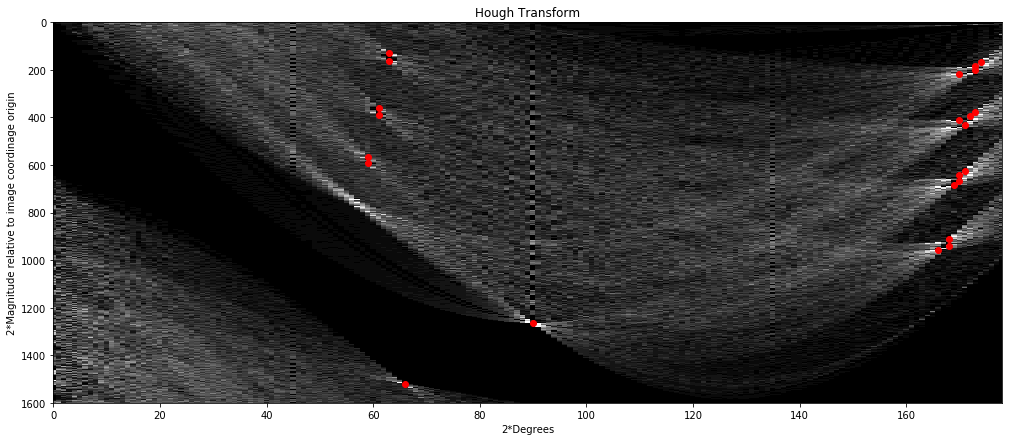

In [6]:
# Adjustable parameters:
theta_resolution = 0.5;
rho_resolution = 0.5;
number_of_peaks = 25;

# read edge-detected image, create hough image, save.
binary_img = cv2.imread("results/test1/binary_edge_low_threshold.png",0);
A, T, R = hough(binary_img, theta_resolution, rho_resolution);
cv2.imwrite('results/test1/accumulator.png',A);

# Detect peaks.
peaks_x_plot, peaks_y_plot = hough_peaks(A, number_of_peaks);

# # use P space indices as indices to obtain corresponding T and R
# # to take into accounf of image space resolution.
peaks_x = T[peaks_x_plot];
peaks_y = R[peaks_y_plot];
print("Coordinates of Peaks on Plot:")
print(peaks_x_plot, "\n", peaks_y_plot);
# print("Actual coordinates of Peaks:")
print(peaks_x);
print(peaks_y);

# plot
fig = plt.figure(figsize = (17,7));
plt.axis([0, 2*T.max(), 2*R.max(), 0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("2*Magnitude relative to image coordinage origin");
plt.xlabel("2*Degrees");
plt.title('Hough Transform');
plt.plot(peaks_x_plot, peaks_y_plot, 'ro')
# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(A, cmap = "gray", norm = colors.Normalize(0,255), aspect = 'auto'); 

### hough_line( )

In [7]:
def houghlines(img, peaks_x, peaks_y):
    line = [];
    
    x_max = img.shape[1]
    y_max = img.shape[0]
    
    #debug
    print("theta and rho:")
    print(peaks_x)
    print(peaks_y)
    
    number_of_lines = len(peaks_x);
    
    # calculate start and stop points of a line at each loop
    for i in range(number_of_lines):
        # find where the line will be placed in image space.
        # +0.01 to avoid division by zero
        #### multiply slope by -1 and offset y by - y_max to take care of flip in y-axis.
        slope = -1/math.tan((peaks_x[i] + 0.01)*math.pi/180);
        y_intercept = peaks_y[i]/math.sin((peaks_x[i] + 0.01)*math.pi/180);
        
        # make coordinates based on slope-intercept form of line equation
        # out of all the edge pixels lies in the line equation, save the left/bottom and right/top most ones.
        # choose lef and right convention for ease, so bother only with x-coordinates of peaks.
        # flag for detected lines.
        line_detection_flag = 0;
        
        # for line_start. scan starting from minimum x val.
        for x_index in range(0,x_max):
            y_index = int(x_index*slope + y_intercept);
            # if line at x=x_index appears in the img.
            if (y_index >= 0) and (y_index < y_max):
                # if corresponding edgel is an edge
                if img[y_index][x_index] == 255:
                    # if the subsequent pixel(top right, right, bottom righ) on the line equation is also an edge, this candidate not a random point, so save it.
                    if (img[y_index+1][x_index+1] == 255) or (img[y_index][x_index+1] == 255) or (img[y_index-1][x_index+1] == 255):
                        line_start = (x_index, y_index);
                        line_detection_flag = 1;
                        temp = x_index;
                        # for line_end. scan starting from same val+1.
                        for new_x_index in range(temp, x_max):
                            new_y_index = int(new_x_index*slope + y_intercept);
                            # if line at x=new_x_index appears in the img.
                            if (y_index >= 0) and (y_index < y_max):
                                # if corresponding edgel is not an edge, terminate by saving this point line_end
                                if img[new_y_index][new_x_index] != 255:
                                    # if the subsequent pixel on the line equation is also not an edge, this candidate not a random non_edge point, so save it.
                                    if (img[new_y_index+1][new_x_index+1] != 255) or (img[new_y_index][new_x_index+1] != 255) or (img[new_y_index-1][new_x_index+1] != 255):
                                        line_end = (new_x_index, new_y_index);
                                        line_detection_flag = 1;
                                        break;
                        break;

        # for lines that never appear on img, skip processing.:
        if (line_detection_flag == 0):
            print("line candidate outside of img");
            number_of_lines = number_of_lines-1;
            continue;
        
        # add two coordinates as a structure
        entry = (line_start, line_end);
        line.append(entry);
    
    print("number_of_lines:", number_of_lines);
    
    return line;

theta and rho:
[-27. -27.  84.  83.  83.  80. -29.  83. -29.  82.  80.  81. -31. -31.
  81.  80.  80.  79.  78.  78.  76.   0. -24.]
[ 65.5  81.5  83.   91.  101.  109.  180.  189.5 194.  197.5 205.5 215.5
 282.5 296.  313.  321.  334.  342.  455.  470.  478.  632.  760.5]
line candidate outside of img
line candidate outside of img
number_of_lines: 21
Start and end coordinates;
(114, 79) (115, 81)
(93, 3) (98, 12)
(239, 58) (240, 58)
(159, 72) (161, 71)
(242, 72) (243, 71)
(6, 109) (10, 108)
(241, 63) (242, 65)
(178, 169) (179, 168)
(223, 2) (226, 7)
(164, 176) (165, 176)
(88, 193) (89, 192)
(188, 188) (189, 188)
(415, 142) (417, 145)
(378, 54) (381, 59)
(454, 245) (455, 244)
(372, 260) (375, 259)
(375, 273) (376, 272)
(156, 318) (157, 317)
(476, 364) (477, 363)
(501, 374) (502, 373)
(160, 452) (161, 452)


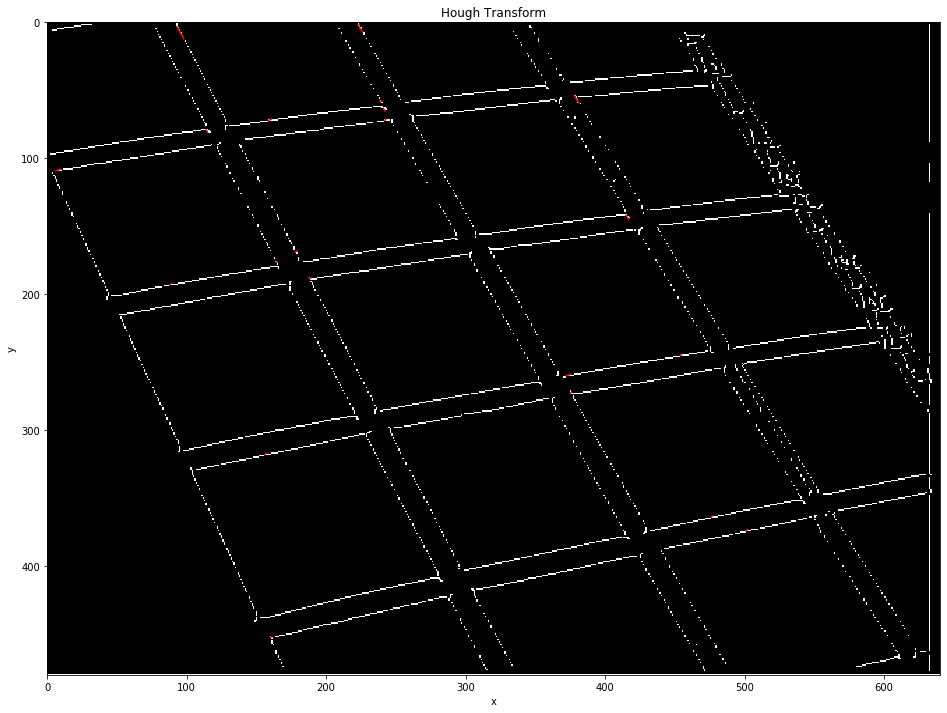

In [8]:
# get lines
lines = houghlines(binary_img, peaks_x, peaks_y) ;

# plot edge image
fig = plt.figure(figsize = (16,12));
# xmin, xmax, ymin, ymax
plt.axis([0, binary_img.shape[1], binary_img.shape[0],0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("y");
plt.xlabel("x");
plt.title('Hough Transform');

# draw lines
print("Start and end coordinates;");
for i in range(len(lines)):
    #  inputting (start_x, end_x), (start_y, end_y)
    plt.plot((lines[i][0][0], lines[i][1][0]), (lines[i][0][1], lines[i][1][1]), 'r');
    print(lines[i][0], lines[i][1]);

# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(binary_img, cmap = "gray", aspect = 'auto'); 

# print(lines)

plt.savefig('results/test1/detected_edges.png')

## Testing and Remarks

The final output image is supposed to cover edges with red lines. However, the truncation of line into a  linesegment becomes overdone, leading to very short segments that looks like red dots on the output. To see how the image looked before truncation, see below:

In [9]:
def houghlines_no_seg(img, peaks_x, peaks_y):
    line = [];
    
    x_max = img.shape[1]
    y_max = img.shape[0]
    
    #debug
    print("theta and rho:")
    print(peaks_x)
    print(peaks_y)
    
    number_of_lines = len(peaks_x);
    print("number_of_lines:", number_of_lines);
    
    # calculate start and stop points of a line at each loop
    for i in range(number_of_lines):
        # find where the line will be placed in image space.
        # +0.01 to avoid division by zero
        #### multiply slope by -1 and offset y by - y_max to take care of flip in y-axis.
        slope = -1/math.tan((peaks_x[i] + 0.01)*math.pi/180);
        y_intercept = peaks_y[i]/math.sin((peaks_x[i] + 0.01)*math.pi/180);
        
        # make coordinates based on slope-intercept form of line equation
        line_start = (0, y_intercept);
        line_end = (x_max, x_max*slope + y_intercept);
        
        # add two coordinates as a structure
        entry = (line_start, line_end);
        line.append(entry);
    
    return line;

theta and rho:
[-27. -27.  84.  83.  83.  80. -29.  83. -29.  82.  80.  81. -31. -31.
  81.  80.  80.  79.  78.  78.  76.   0. -24.]
[ 65.5  81.5  83.   91.  101.  109.  180.  189.5 194.  197.5 205.5 215.5
 282.5 296.  313.  321.  334.  342.  455.  470.  478.  632.  760.5]
number_of_lines: 23
Start and end coordinates;
(0, -144.32558633664942) (640, 1112.2872786267444)
(0, -179.58069139598362) (640, 1077.0321735674102)
(0, 83.45565755181224) (640, 16.30187993399862)
(0, 91.68143078480541) (640, 13.21269446121022)
(0, 101.75631328863018) (640, 23.287576965034987)
(0, 110.67809627795593) (640, -2.0560009256848133)
(0, -371.39670688496676) (640, 783.6692482530877)
(0, 190.9190234474794) (640, 112.4502871238842)
(0, -400.2831174204642) (640, 754.7828377175904)
(0, 199.43605664240692) (640, 109.60382700119025)
(0, 208.66375032220134) (640, 95.9296531185606)
(0, 218.1802067095824) (640, 116.92866490188221)
(0, -548.6625166773711) (640, 516.8975680102619)
(0, -574.8817873858472) (640, 490.678

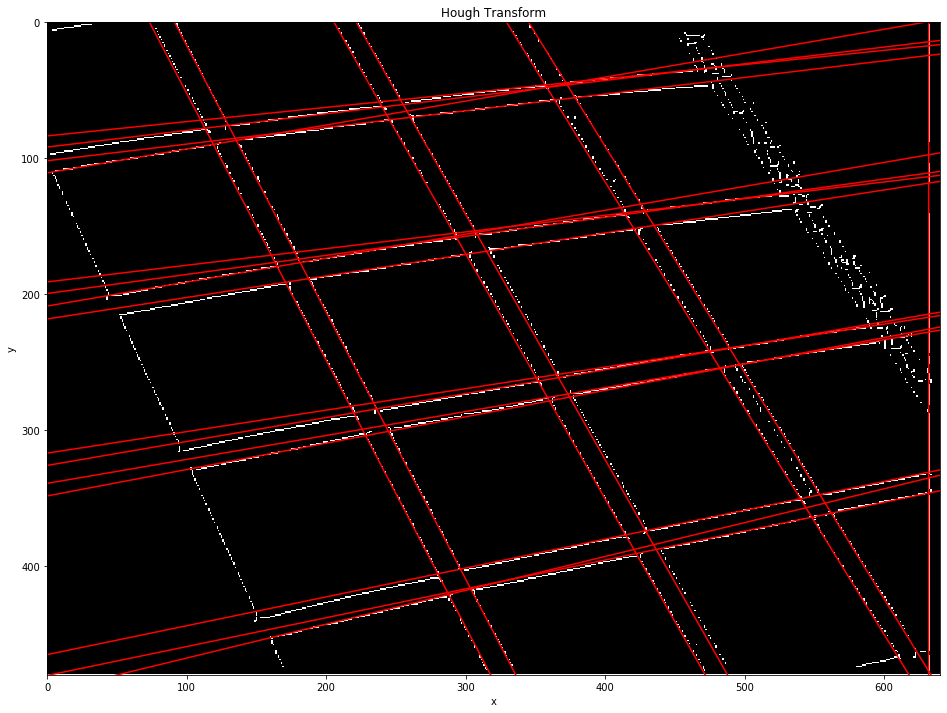

In [10]:
# get lines
lines = houghlines_no_seg(binary_img, peaks_x, peaks_y) ;

# plot edge image
fig = plt.figure(figsize = (16,12));
# xmin, xmax, ymin, ymax
plt.axis([0, binary_img.shape[1], binary_img.shape[0],0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("y");
plt.xlabel("x");
plt.title('Hough Transform');

# draw lines
print("Start and end coordinates;");
for i in range(len(lines)):
    #  inputting (start_x, end_x), (start_y, end_y)
    plt.plot((lines[i][0][0], lines[i][1][0]), (lines[i][0][1], lines[i][1][1]), 'r');
    print(lines[i][0], lines[i][1]);

# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(binary_img, cmap = "gray", aspect = 'auto'); 

# print(lines)

plt.savefig('results/test1/detected_edges_no_seg.png')

As seen in the image, most of the edges are detected quite accurately. This was achieved with a uniquely selected number of target lines and threshold for neighor suppression of the Hugh accumulator peaks. Optimal set of parameters vary with what test images to use. Take the case for test image 2:

Input size: (480, 640)
Edge Pixel Count for strong_threshold =  30 , weak_threshold = 10 : 3885
	Edge/Image Size Percentage: 1.3 %
Edge Pixel Count for strong_threshold =  40 , weak_threshold = 20 : 3229
	Edge/Image Size Percentage: 1.1 %
Edge Pixel Count for strong_threshold =  50 , weak_threshold = 30 : 2937
	Edge/Image Size Percentage: 1.0 %
theta size:  180
img dimension: y_max = 480 , x_max = 640
Number of detected_peaks: 10
number_of_peaks exceeds detected_peaks. Returning 10 peaks.
Coordinates of Peaks on Plot:
[21, 21, 167, 90, 90, 165, 90, 165, 90, 20] 
 [11, 12, 526, 564, 592, 733, 782, 846, 1262, 1593]
[-69. -69.  77.   0.   0.  75.   0.  75.   0. -70.]
[  5.5   6.  263.  282.  296.  366.5 391.  423.  631.  796.5]


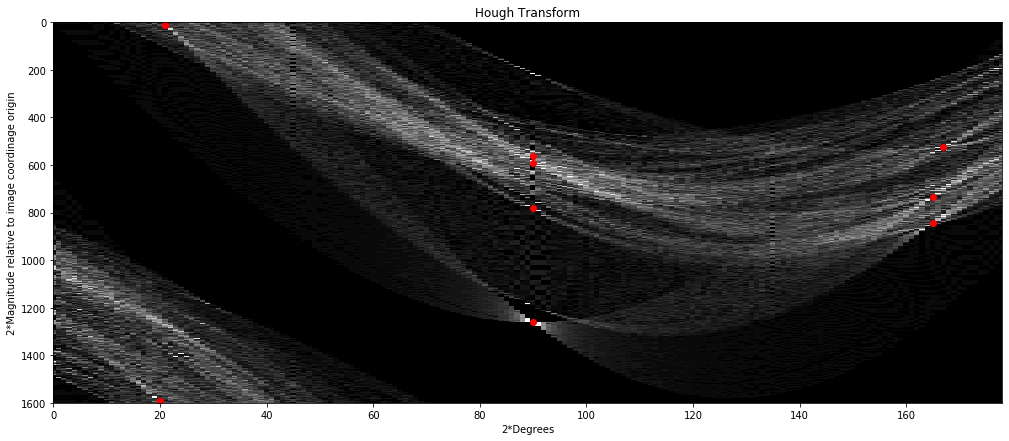

In [11]:
# read input image for edge detection
input_img = cv2.imread("test_image/img02.jpg",0);

# declare image variables based on input image size
gradient_mag = np.zeros((input_img.shape)).astype(int);
gradient_angle = np.zeros((input_img.shape)).astype(int);
quant = np.zeros((input_img.shape)).astype(int);
suppressed = np.zeros((input_img.shape)).astype(int);
binary_edge_low = np.zeros((input_img.shape)).astype(int);
binary_edge_mid = np.zeros((input_img.shape)).astype(int);
binary_edge_high = np.zeros((input_img.shape)).astype(int);

# Gaussian Smoothing
print("Input size:", input_img.shape)
output=filter(input_img,gaussian)
cv2.imwrite('results/test2/smooth.png',output)

# Gradient Operation
smooth = cv2.imread("results/test2/smooth.png",0);
gradient_horizontal=filter(smooth,prewritt_horizontal);
cv2.imwrite('results/test2/gradient_horizontal.png',gradient_horizontal);
gradient_vertical=filter(smooth,prewritt_vertical);
cv2.imwrite('results/test2/gradient_vertical.png',gradient_vertical);

## Non-Maximum Suppression

# Gradient Magnitude & Direction
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        gradient_mag[i][j]=int((gradient_horizontal[i][j]**2+gradient_vertical[i][j]**2)**(1/2));
        if (gradient_horizontal[i][j]!=0):
            #arctan is in radians. multiply by 180/pi dy/dx
            gradient_angle[i][j]=(180/math.pi)*np.arctan(gradient_vertical[i][j]/gradient_horizontal[i][j]);
        #if dx=0, result is -90 or 90
        elif (gradient_vertical[i][j]>0):
            gradient_angle[i][j]=90;
        elif (gradient_vertical[i][j]<0):
            gradient_angle[i][j]=-90;
        # 0 if both dx and dy is 0
        else:
            gradient_angle[i][j]=0

cv2.imwrite('results/test2/gradient_mag.png',gradient_mag);

# Quantization bounds:
# 2:more than 67.5 or less than -67.5
# 1:22.5~67.5
# 0: -22.5~22.5
# 3:-67.5~-22.5
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        if (gradient_angle[i][j]> 67.5) or (gradient_angle[i][j]< -67.5):
            quant[i][j]=2;
        elif gradient_angle[i][j]> 22.5:
            quant[i][j]=1;
        elif gradient_angle[i][j]> -22.5:
            quant[i][j]=0;
        else:
            quant[i][j]=3;

# Non-Maxima Suppression
# +1, -1 to keep iteration within boundary 
for i in range(1,input_img.shape[0]-1):
    # according to class lecture #2
    for j in range(1,input_img.shape[1]-1):
        if (quant[i][j]==2):
            if (gradient_mag[i][j]>gradient_mag[i-1][j]) and (gradient_mag[i][j]>gradient_mag[i+1][j]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==1):
            if (gradient_mag[i][j]>gradient_mag[i+1][j-1]) and (gradient_mag[i][j]>gradient_mag[i-1][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==0):
            if (gradient_mag[i][j]>gradient_mag[i][j-1]) and (gradient_mag[i][j]>gradient_mag[i][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==3):
            if (gradient_mag[i][j]>gradient_mag[i-1][j-1]) and (gradient_mag[i][j]>gradient_mag[i+1][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        else:
            suppressed[i][j]=0
cv2.imwrite('results/test2/suppressed.png',suppressed);


# Double thresholding: weak_threshold for 3 different values. keep stronge_threshold unchanged for now.
# test1 : edge is 1% of image area
# test2 : edge is 2% of image area
stronge_threshold=30
weak_threshold = 10 #minimum percentage of edge
binary_edge_low = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_low)
cv2.imwrite('results/test2/binary_edge_low_threshold.png',binary_edge_low);

stronge_threshold=40
weak_threshold = 20 #minimum percentage of edge
binary_edge_mid = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_mid)
cv2.imwrite('results/test2/binary_edge_mid_threshold.png',binary_edge_mid);

stronge_threshold=50
weak_threshold = 30 #minimum percentage of edge
binary_edge_high = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_high)
cv2.imwrite('results/test2/binary_edge_high_threshold.png',binary_edge_high);

# Adjustable parameters:
theta_resolution = 0.5;
rho_resolution = 0.5;
number_of_peaks = 25;

# read edge-detected image, create hough image, save.
binary_img = cv2.imread("results/test2/binary_edge_low_threshold.png",0);
A, T, R = hough(binary_img, theta_resolution, rho_resolution);
cv2.imwrite('results/test2/accumulator.png',A);

# Detect peaks.
peaks_x_plot, peaks_y_plot = hough_peaks(A, number_of_peaks);

# # use P space indices as indices to obtain corresponding T and R
# # to take into accounf of image space resolution.
peaks_x = T[peaks_x_plot];
peaks_y = R[peaks_y_plot];
print("Coordinates of Peaks on Plot:")
print(peaks_x_plot, "\n", peaks_y_plot);
# print("Actual coordinates of Peaks:")
print(peaks_x);
print(peaks_y);

# plot
fig = plt.figure(figsize = (17,7));
plt.axis([0, 2*T.max(), 2*R.max(), 0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("2*Magnitude relative to image coordinage origin");
plt.xlabel("2*Degrees");
plt.title('Hough Transform');
plt.plot(peaks_x_plot, peaks_y_plot, 'ro')
# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(A, cmap = "gray", norm = colors.Normalize(0,255), aspect = 'auto'); 

theta and rho:
[-69. -69.  77.   0.   0.  75.   0.  75.   0. -70.]
[  5.5   6.  263.  282.  296.  366.5 391.  423.  631.  796.5]
line candidate outside of img
line candidate outside of img
line candidate outside of img
line candidate outside of img
line candidate outside of img
number_of_lines: 5
Start and end coordinates;
(227, 81) (229, 82)
(231, 82) (233, 83)
(111, 244) (113, 243)
(248, 313) (249, 312)
(388, 334) (389, 333)


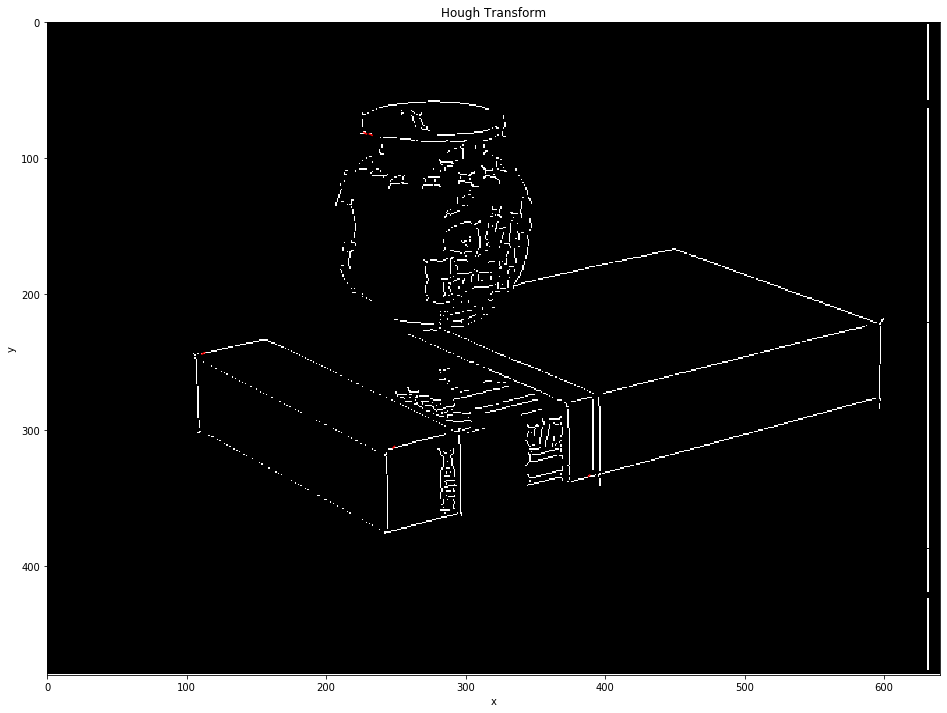

In [12]:
# get lines
lines = houghlines(binary_img, peaks_x, peaks_y) ;

# plot edge image
fig = plt.figure(figsize = (16,12));
# xmin, xmax, ymin, ymax
plt.axis([0, binary_img.shape[1], binary_img.shape[0],0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("y");
plt.xlabel("x");
plt.title('Hough Transform');

# draw lines
print("Start and end coordinates;");
for i in range(len(lines)):
    #  inputting (start_x, end_x), (start_y, end_y)
    plt.plot((lines[i][0][0], lines[i][1][0]), (lines[i][0][1], lines[i][1][1]), 'r');
    print(lines[i][0], lines[i][1]);

# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(binary_img, cmap = "gray", aspect = 'auto'); 

# print(lines)

plt.savefig('results/test2/detected_edges.png')

theta and rho:
[-69. -69.  77.   0.   0.  75.   0.  75.   0. -70.]
[  5.5   6.  263.  282.  296.  366.5 391.  423.  631.  796.5]
number_of_lines: 10
Start and end coordinates;
(0, -5.891692279931853) (640, 239.90945913449877)
(0, -6.427300669016566) (640, 239.37385074541405)
(0, 269.9071087964072) (640, 122.26911648950309)
(0, 1615740.990471969) (640, -2051188.8611316085)
(0, 1695955.0821975276) (640, -1970974.7694060497)
(0, 379.4109823817007) (640, 208.04321447668073)
(0, 2240264.9903352475) (640, -1426664.86126833)
(0, 437.9013521076655) (640, 266.53358420264556)
(0, 3615363.7056305404) (640, -51566.145973037)
(0, -847.6714568385719) (640, -614.6040002736324)


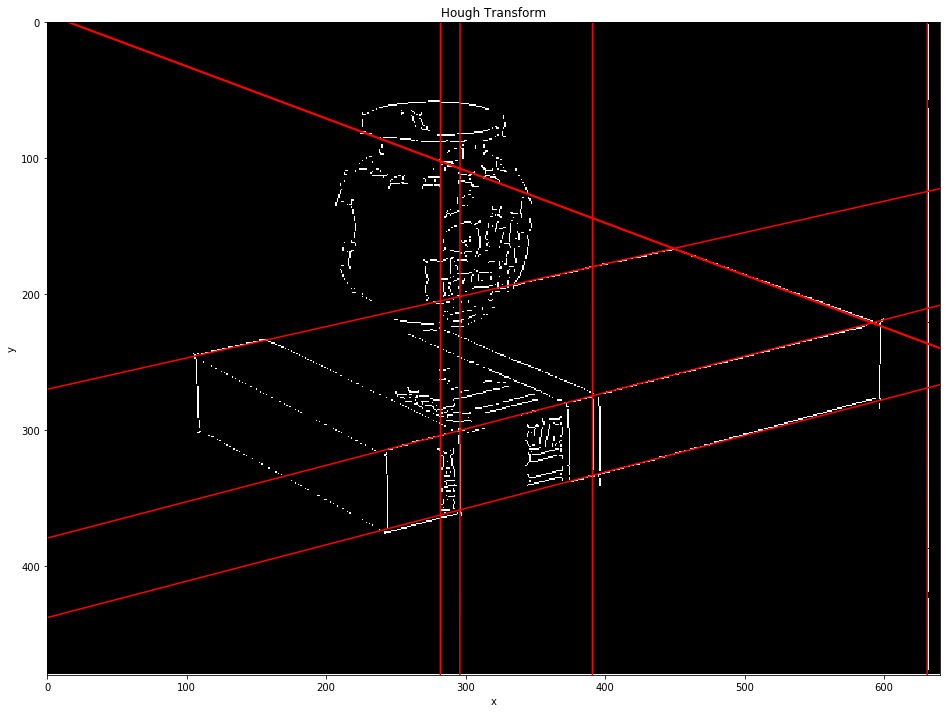

In [13]:
# get lines
lines = houghlines_no_seg(binary_img, peaks_x, peaks_y) ;

# plot edge image
fig = plt.figure(figsize = (16,12));
# xmin, xmax, ymin, ymax
plt.axis([0, binary_img.shape[1], binary_img.shape[0],0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("y");
plt.xlabel("x");
plt.title('Hough Transform');

# draw lines
print("Start and end coordinates;");
for i in range(len(lines)):
    #  inputting (start_x, end_x), (start_y, end_y)
    plt.plot((lines[i][0][0], lines[i][1][0]), (lines[i][0][1], lines[i][1][1]), 'r');
    print(lines[i][0], lines[i][1]);

# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(binary_img, cmap = "gray", aspect = 'auto'); 

# print(lines)

plt.savefig('results/test2/detected_edges_no_seg.png')

The same parameter from test image 1 was used, and it seems that this setting was still able to find edges for image 2 well. However, like test image 1, line segmentation did not work well. In general, lower threshold value for hugh accumulator peak suppression increases detected lines, but could detect more erroneous lines. For future improvements, the algorithm for detecting line segment should have a more robust condition for finding multiple edges that lie on the same line.

To see how other test images fare, go to "ken_iiyoshi_hough_transform_ver14b_test_other_imagesipynb", and maually type in the image name in the test_images folder. Note that this will replace the output result in "results/test1" folder.

Using the same parameters, some edges were detected for img03, none for img04 to 09 (errorneous lines due to detecting trivial patterns from lack of connected edges, or no line that crosses into the img boundary). Especially for images that had noisy edges (i.e. looking more like speckles and curves than straight lines), it seems that hough tranform performs poorly.